In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "data"

In [2]:
df_wide = pd.read_excel(f"{data_path}/italy_wikipedia.xlsx", sheet_name='Wide',
                        parse_dates=True, dayfirst=True)
df_wide['Growth_Rate'] = df_wide['Confirmed_New'].divide(df_wide['Active_Total'])
df_wide.head()

,Date,VDA_Confirmed,VDA_Deaths,LIG_Confirmed,LIG_Deaths,PIE_Confirmed,PIE_Deaths,LOM_Confirmed,LOM_Deaths,VEN_Confirmed,...,SAR_Deaths,Confirmed_New,Confirmed_Total,Deaths_New,Deaths_Total,Active_ICU,Active_Total,Recovered,Tested,Growth_Rate
0,2020-01-31,0,0,0,0,0,0,0,0,0,...,0,2,2,0,0,0,2,0,0,1.000000
1,2020-02-06,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,3,0,0,0.333333
2,2020-02-21,0,0,0,0,0,0,15,0,2,...,0,17,20,1,1,0,19,0,0,0.894737
3,2020-02-22,0,0,0,0,1,0,40,1,16,...,0,59,79,1,2,18,75,0,0,0.786667
4,2020-02-23,0,0,0,0,2,0,57,1,7,...,0,71,150,1,3,25,147,0,0,0.482993


In [3]:
df_policy = pd.read_excel(f"{data_path}/italy_wikipedia.xlsx", sheet_name="NationwideRestrictions",
                          parse_dates=True, dayfirst=True)
df_policy = df_policy.dropna()
df_policy.head()

,Date,SyptomaticTested,SchoolsClosed,Lockdown,CommericalActivityProhibition,FreeMovementRestrictions,HaltingAllNonEssentialBusinesses,HigherFines
0,2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_eurostat = pd.read_csv(f"{data_path}/eurostat/merged_eurostat.csv")
df_eurostat.head()

,region,time,air_freight_loaded,air_freight_unloaded,air_passengers_arrived,air_passengers_departed,area,tourist_arrivals,hospital_stay,broadband_access,...,maritime_freight_unloaded,maritime_passengers_disembarked,maritime_passengers_embarked,median_age,lower_education,tertiary_education,higher_education,population_density,population_numbers,risk_of_poverty_or_social_exclusion
0,Abruzzo,1990,NaN,NaN,NaN,NaN,10833.0,920164.0,NaN,NaN,...,NaN,NaN,NaN,37.4,NaN,NaN,NaN,115.3,1243014.0,NaN
1,Basilicata,1990,NaN,NaN,NaN,NaN,10073.0,187695.0,NaN,NaN,...,NaN,NaN,NaN,33.7,NaN,NaN,NaN,61.1,611029.0,NaN
2,Calabria,1990,NaN,NaN,NaN,NaN,15222.0,676446.0,NaN,NaN,...,NaN,NaN,NaN,32.1,NaN,NaN,NaN,137.8,2080660.0,NaN
3,Campania,1990,NaN,NaN,NaN,NaN,13670.0,2146643.0,NaN,NaN,...,NaN,NaN,NaN,30.5,NaN,NaN,NaN,413.0,5607965.0,NaN
4,Centro (IT),1990,NaN,NaN,NaN,NaN,58085.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# We fill NAs by the average of the value directly before and directly after
for col in df_wide.columns[df_wide.isna().any(axis=0)]:
    df_wide[col] = df_wide[col].fillna((df_wide[col].shift() + df_wide[col].shift(-1))/2)

# We will not allow for negative values. These are defined as corrections due to cases that were
# subsequently declared negative. So, we will go backwards to subtract these corrections from the
# most recent value above
neg_cols = (df_wide.iloc[:, 1:] < 0).any(axis=0)
neg_cols = neg_cols.index[neg_cols]

for col in neg_cols:
    # Find rows in which the value is negative
    indices = df_wide.index[df_wide[col] < 0]
    
    # Look at indices in reverse
    for index in indices[::-1]:
        df_wide.loc[index-1, col] = df_wide.loc[index-1, col] + df_wide.loc[index, col]
        df_wide.loc[index, col] = 0

We do not have the number of active cases per region and this is difficult to compute since there is no data on the number of recoveries per region. For now, we will assume that the number of recoveries is 0 and we can then later assume that the number of recoveries per region is proportional to the number of confirmed cases (i.e. if Lombardy has 40% of the confirmed cases on that day (or with a certain lag), it gets 40% of the nationwide recoveries).

In [6]:
regions = set([col for col in [col.split("_")[0] for col in df_wide.columns] if col.upper() == col])

# We choose one specific region first
region = "LOM"

df_region = df_wide[['Date', f"{region}_Confirmed", f"{region}_Deaths"]].copy()
df_region['Total'] = df_region[f"{region}_Confirmed"].cumsum()
df_region['Active'] = df_region['Total'].subtract(df_region[f"{region}_Deaths"])

df_region['Growth_Rate'] = df_region[f"{region}_Confirmed"].divide(df_region['Active'])
df_region.head()

,Date,LOM_Confirmed,LOM_Deaths,Total,Active,Growth_Rate
0,2020-01-31,0,0,0,0,NaN
1,2020-02-06,0,0,0,0,NaN
2,2020-02-21,15,0,15,15,1.000000
3,2020-02-22,40,1,55,54,0.740741
4,2020-02-23,57,1,112,111,0.513514


C:\Users\mikew\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


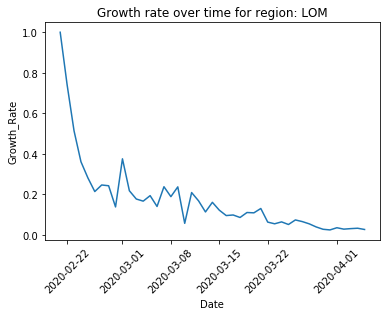

In [7]:
sns.lineplot(x='Date', y='Growth_Rate', data=df_region)
plt.xticks(rotation=45)
plt.title(f"Growth rate over time for region: {region}")
plt.show()

Since we do not know the population for 31 January 2020, we need to make some assumption about this. From https://www.tuttitalia.it/regioni/, we know the population per region on 1 January 2019. From https://www.worldometers.info/world-population/italy-population/, we see that the yearly growth rate for Italy in 2019 was -0.13% and for 2020 it is estimated to be -0.15% (not taking the coronacrisis into account). We assume that this is constant for all regions, for lack of a better metric.

For Lombardy, for instance, this means that its population on 31 January 2020 is estimated to be:

In [8]:
population = round(10060574 * 0.87 * 0.85**(30/366))
population

8636876

For lack of data, we assume that all deaths in this time period were due to the coronacrisis. We define the susceptible population as the total population subtracting the confirmed cases and the deaths.

In [9]:
susceptibles = [0]*len(df_region)
susceptibles[0] = population

for ind in range(1, len(df_region)):
    susceptibles[ind] = susceptibles[ind-1] - df_region.loc[ind, f"{region}_Confirmed"] - df_region.loc[ind, f"{region}_Deaths"]
    
df_region['Susceptible'] = susceptibles
df_region.head()

,Date,LOM_Confirmed,LOM_Deaths,Total,Active,Growth_Rate,Susceptible
0,2020-01-31,0,0,0,0,NaN,8636876
1,2020-02-06,0,0,0,0,NaN,8636876
2,2020-02-21,15,0,15,15,1.000000,8636861
3,2020-02-22,40,1,55,54,0.740741,8636820
4,2020-02-23,57,1,112,111,0.513514,8636762


We want to model the growth rate $G_t$ for one specific region as follows:

$$ G_t = G_{t-lag}S_{t-lag} \cdot \sum_{k=1}^K a^kW^k_{t-lag} $$

Using the data in `df_policy`, this can be read as:

$$ G_t = G_{t-lag}S_{t-lag} \cdot aW_{t-lag} $$

where $a = \begin{pmatrix}a^{SyptomiaticTested}, \dots, a^{HigherFines}\end{pmatrix}^{\top} \in \mathbb{R}^{1 \times K}$ and $W = \begin{pmatrix} W^{SyptomiaticTested}, \dots, W^{HigherFines} \end{pmatrix} \in \mathbb{R}^{T \times K}$. $W$ represents the columns of `df_policy`.

In [10]:
df_policy.head()

,Date,SyptomaticTested,SchoolsClosed,Lockdown,CommericalActivityProhibition,FreeMovementRestrictions,HaltingAllNonEssentialBusinesses,HigherFines
0,2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
lag = 1
W = df_policy.copy()
W = W.shift(-lag)
W

,Date,SyptomaticTested,SchoolsClosed,Lockdown,CommericalActivityProhibition,FreeMovementRestrictions,HaltingAllNonEssentialBusinesses,HigherFines
0,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2020-02-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_policy.shape

(47, 8)

If we want to model the number of confirmed cases, then this is not a bounded problem (only bounded below from 0, which we currently assume is no problem). As such, we can perform a simple linear regression to model

$$ C_t = C_{t-lag}S_{t-lag} \cdot \sum_{k=1}^K a^kW^k_{t-lag} $$

In [45]:
cols_policy = list(df_policy.columns)[1:]

Ct = df_region[['Date', f"{region}_Confirmed"]].copy()
CtimesSt_lag = df_region[['Date', f"{region}_Confirmed", 'Susceptible']].copy().shift(-lag)
Wt_lag = df_policy[['Date'] + cols_policy].copy().shift(-lag)

X = CtimesSt_lag.merge(Wt_lag, on='Date').dropna()

for policy in cols_policy:
    X[f"Product_{policy}"] = X[f"{region}_Confirmed"].multiply(X['Susceptible']).multiply(X[policy])

X

,Date,LOM_Confirmed,Susceptible,SyptomaticTested,SchoolsClosed,Lockdown,CommericalActivityProhibition,FreeMovementRestrictions,HaltingAllNonEssentialBusinesses,HigherFines,Product_SyptomaticTested,Product_SchoolsClosed,Product_Lockdown,Product_CommericalActivityProhibition,Product_FreeMovementRestrictions,Product_HaltingAllNonEssentialBusinesses,Product_HigherFines
0,2020-02-06,0.0,8636876.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2020-02-21,15.0,8636861.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2020-02-22,40.0,8636820.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2020-02-23,57.0,8636762.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2020-02-24,61.0,8636697.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,2020-02-25,67.0,8636628.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,2020-02-26,65.0,8636562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,2020-02-27,98.0,8636459.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.463730e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,2020-02-28,128.0,8636328.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105450e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2020-02-29,84.0,8636238.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.254440e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [55]:
df = Ct.merge(X[['Date'] + [f"Product_{policy}" for policy in cols_policy]])

In [67]:
df['Weekend'] = [1 if date.weekday() >= 5 else 0 for date in df['Date']]

Clearly, since the policies are highly correlated, an additional policy does not add predictive value. In the below regression results, we can see this is the case due to the high p-values.

In [71]:
import statsmodels.api as sm
results = sm.OLS(df[f"{region}_Confirmed"], df[[f"Product_{policy}" for policy in cols_policy] + ["Weekend"]]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          LOM_Confirmed   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.518e+04
Date:                Mon, 06 Apr 2020   Prob (F-statistic):                    2.64e-68
Time:                        16:12:06   Log-Likelihood:                         -200.39
No. Observations:                  46   AIC:                                      416.8
Df Residuals:                      38   BIC:                                      431.4
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Product_SyptomaticTested                  1.138e-07   4.46e-09     25.542      0.000    1.05e-07    1.23e-07
Product_SchoolsClosed                     6.977e-10    4.7e-09      0.148      0.883   -8.83e-09    1.02e-08
Product_Lockdown                          1.321e-09   2.73e-09      0.485      0.631    -4.2e-09    6.84e-09
Product_CommericalActivityProhibition    -7.526e-11   1.89e-09     -0.040      0.969   -3.91e-09    3.76e-09
Product_FreeMovementRestrictions          3.307e-10   1.14e-09      0.291      0.773   -1.97e-09    2.63e-09
Product_HaltingAllNonEssentialBusinesses -3.584e-10   1.21e-09     -0.297      0.768    -2.8e-09    2.09e-09
Product_HigherFines                       4.075e-10   7.29e-10      0.559      0.579   -1.07e-09    1.88e-09
Weekend                                     11.6664      7.063      1.652      0.107      -2.631      25.964
==============================================================================
Omnibus:                       38.936   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.955
Skew:                           2.444   Prob(JB):                     1.46e-21
Kurtosis:                       8.115   Cond. No.                     6.17e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""